# 2-Channel Image Analysis: Muscle Cell and Nuclei Segmentation

This notebook performs two segmentation tasks on 2-channel fluorescence images:
1. **Muscle Cell Segmentation (Channel 1):** Segments individual muscle cells based on membrane marker
2. **Nuclei Segmentation (Channel 2):** Segments nuclei within each cell

Both use Cellpose for deep learning-based segmentation.

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile
from cellpose import models
import torch

# Check for GPU
use_gpu = torch.cuda.is_available()
print(f"GPU Available: {use_gpu}")

GPU Available: True


In [14]:
# Check available Cellpose models
from cellpose import models

print("Available Cellpose models:")
print(f"  - nuclei (best for nuclei segmentation)")
print(f"  - cyto3 (general cellular objects)")
print(f"  - cyto2 (older general model)")
print(f"  - cyto (oldest general model)")
print(f"\nFor nuclei segmentation, use: model_type='nuclei'")
print(f"For cells with membranes, use: model_type='cyto3'")

Available Cellpose models:
  - nuclei (best for nuclei segmentation)
  - cyto3 (general cellular objects)
  - cyto2 (older general model)
  - cyto (oldest general model)

For nuclei segmentation, use: model_type='nuclei'
For cells with membranes, use: model_type='cyto3'


Loaded: S:\micro\ts2625\eh2888\lem\20260128_EVE_IMARE-143312\CodeTesting\WT_Gastro_right002.tif
Image shape: (2, 4500, 4499)
Channel 1 (cells) shape: (4500, 4499)
Channel 2 (nuclei) shape: (4500, 4499)


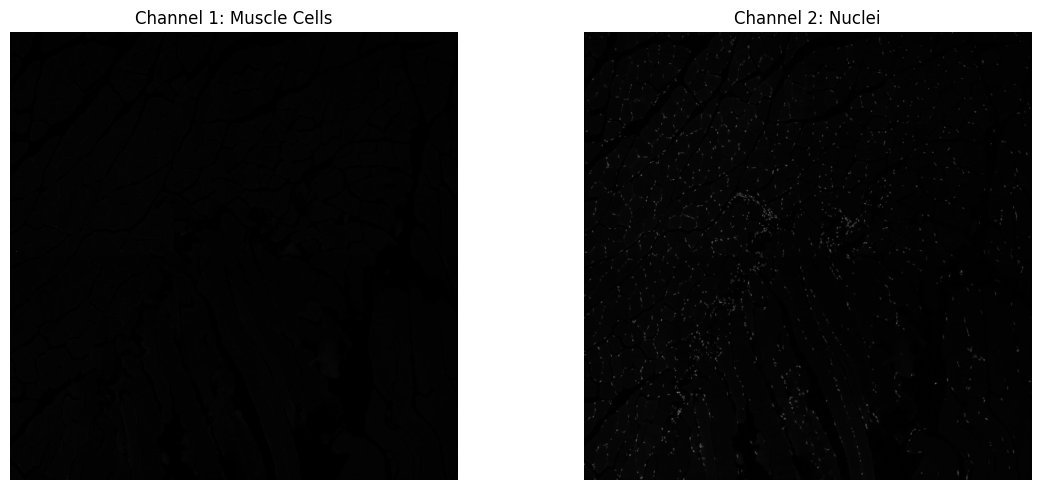

In [4]:
# Load 2-channel TIF image
IMAGE_PATH = r"S:\micro\ts2625\eh2888\lem\20260128_EVE_IMARE-143312\CodeTesting\WT_Gastro_right002.tif"  # Update to your 2-channel TIF file

img = tifffile.imread(IMAGE_PATH)
print(f"Loaded: {IMAGE_PATH}")
print(f"Image shape: {img.shape}")

# Ensure shape is (height, width, channels)
if img.ndim == 3 and img.shape[0] < 5:  # Likely (channels, height, width)
    img = np.transpose(img, (1, 2, 0))

# Extract channels
ch_cells = img[..., 0]      # Channel 1: Muscle cells with membrane marker
ch_nuclei = img[..., 1]     # Channel 2: Nuclei

print(f"Channel 1 (cells) shape: {ch_cells.shape}")
print(f"Channel 2 (nuclei) shape: {ch_nuclei.shape}")

# Quick visualization
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].imshow(ch_cells, cmap='gray')
ax[0].set_title("Channel 1: Muscle Cells")
ax[0].axis('off')
ax[1].imshow(ch_nuclei, cmap='gray')
ax[1].set_title("Channel 2: Nuclei")
ax[1].axis('off')
plt.tight_layout()
plt.show()

## Cell Segmentation (Channel 1)

In [9]:
# 1. Muscle Segmentation
# Set expected diameter (in pixels) to speed up processing
# Set to None for auto-estimation (slower)

model_cyto = models.CellposeModel(gpu=use_gpu, model_type='cyto3')

masks_cells, flows, styles = model_cyto.eval(
    ch_cells, 
    diameter=120, 
    flow_threshold=0.3, 
    cellprob_threshold=-1,
    channels=[0, 0]  # Single channel input
)

# Quick verify
viewer = napari.Viewer()
# View with napari
print("\nOpen Napari viewer for Muscle Cell Segmentation...")
viewer_cells = napari.Viewer()
viewer_cells.add_image(ch_cells, name='RGB Image')
viewer_cells.add_labels(masks_cells, name='Muscle Cells')
print(f"Found {masks_cells.max()} muscle cells")

model_type argument is not used in v4.0.1+. Ignoring this argument...
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
Resizing is deprecated in v4.0.1+



Open Napari viewer for Muscle Cell Segmentation...
Found 515 muscle cells


## Nuclei Segmentation (Channel 2)

In [31]:
# Segment nuclei using Cellpose
print("Segmenting nuclei...")

# Use the 'nuclei' model which is specifically trained for nuclear segmentation
model_nuclei = models.CellposeModel(gpu=use_gpu, model_type='nuclei')

masks_nuclei, flows, styles = model_nuclei.eval(
    ch_nuclei, 
    diameter=10, 
    flow_threshold=0.4, 
    cellprob_threshold=-1,
    channels=[0, 0]  # Single channel input
)

print(f"Found {masks_nuclei.max()} nuclei")

# Visualize


model_type argument is not used in v4.0.1+. Ignoring this argument...


Segmenting nuclei...


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
Resizing is deprecated in v4.0.1+


Found 1794 nuclei


In [30]:
# View with napari
print("\nOpen Napari viewer for Muscle Cell Segmentation...")
viewer_cells = napari.Viewer()
viewer_cells.add_image(ch_nuclei, name='RGB Image')
viewer_cells.add_labels(masks_nuclei, name='Muscle Cells')
print(f"Found {masks_nuclei.max()} muscle cells")


Open Napari viewer for Muscle Cell Segmentation...
Found 1518 muscle cells


## Save Results

In [24]:
# Save masks as 2-channel TIF image
import os

# Create output filename (same path as input, but with _masks suffix)
base_path = os.path.splitext(IMAGE_PATH)[0]
output_path = f"{base_path}_masks.tif"

# Stack masks into 2-channel image
masks_2ch = np.stack([masks_cells, masks_nuclei], axis=0)

# Save as TIF
tifffile.imwrite(output_path, masks_2ch)
print(f"Saved 2-channel mask to: {output_path}")
print(f"  Channel 0: Cell masks ({masks_cells.max()} cells)")
print(f"  Channel 1: Nuclei masks ({masks_nuclei.max()} nuclei)")

# Optional: Save individual masks as well
cells_path = f"{base_path}_masks_cells.tif"
nuclei_path = f"{base_path}_masks_nuclei.tif"
tifffile.imwrite(cells_path, masks_cells)
tifffile.imwrite(nuclei_path, masks_nuclei)
print(f"\nAlso saved individual masks:")
print(f"  {cells_path}")
print(f"  {nuclei_path}")

Saved 2-channel mask to: S:\micro\ts2625\eh2888\lem\20260128_EVE_IMARE-143312\CodeTesting\WT_Gastro_right002_masks.tif
  Channel 0: Cell masks (515 cells)
  Channel 1: Nuclei masks (1805 nuclei)

Also saved individual masks:
  S:\micro\ts2625\eh2888\lem\20260128_EVE_IMARE-143312\CodeTesting\WT_Gastro_right002_masks_cells.tif
  S:\micro\ts2625\eh2888\lem\20260128_EVE_IMARE-143312\CodeTesting\WT_Gastro_right002_masks_nuclei.tif
